In [1]:
import cv2
import glob
import mlflow
from scipy import io
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from warnings import filterwarnings
filterwarnings(action='ignore')
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, plot_confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve

In [2]:
iterate = np.arange(0, 10000)
iterate = iter(iterate)

In [3]:
mat = io.loadmat('imagelabels.mat')

for name, value in mat.items():
    print(name, value, sep='/n')

__header__/nb'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009'
__version__/n1.0
__globals__/n[]
labels/n[[77 77 77 ... 62 62 62]]


In [4]:
mat['labels'][0]

array([77, 77, 77, ..., 62, 62, 62], dtype=uint8)

In [5]:
np.unique(mat['labels'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102], dtype=uint8)

In [6]:
labels = mat['labels'][0]
len(labels)

8189

In [7]:
data = glob.glob('jpg/*')

In [8]:
df = pd.DataFrame({'data': data, 'labels': labels})
df

data  labels
0     jpg\image_00001.jpg      77
1     jpg\image_00002.jpg      77
2     jpg\image_00003.jpg      77
3     jpg\image_00004.jpg      77
4     jpg\image_00005.jpg      77
...                   ...     ...
8184  jpg\image_08185.jpg      62
8185  jpg\image_08186.jpg      62
8186  jpg\image_08187.jpg      62
8187  jpg\image_08188.jpg      62
8188  jpg\image_08189.jpg      62

[8189 rows x 2 columns]

In [9]:
df[df['labels'] == 1].data.values.tolist()

['jpg\\image_06734.jpg',
 'jpg\\image_06735.jpg',
 'jpg\\image_06736.jpg',
 'jpg\\image_06737.jpg',
 'jpg\\image_06738.jpg',
 'jpg\\image_06739.jpg',
 'jpg\\image_06740.jpg',
 'jpg\\image_06741.jpg',
 'jpg\\image_06742.jpg',
 'jpg\\image_06743.jpg',
 'jpg\\image_06744.jpg',
 'jpg\\image_06745.jpg',
 'jpg\\image_06746.jpg',
 'jpg\\image_06747.jpg',
 'jpg\\image_06748.jpg',
 'jpg\\image_06749.jpg',
 'jpg\\image_06750.jpg',
 'jpg\\image_06751.jpg',
 'jpg\\image_06752.jpg',
 'jpg\\image_06753.jpg',
 'jpg\\image_06754.jpg',
 'jpg\\image_06755.jpg',
 'jpg\\image_06756.jpg',
 'jpg\\image_06757.jpg',
 'jpg\\image_06758.jpg',
 'jpg\\image_06759.jpg',
 'jpg\\image_06760.jpg',
 'jpg\\image_06761.jpg',
 'jpg\\image_06762.jpg',
 'jpg\\image_06763.jpg',
 'jpg\\image_06764.jpg',
 'jpg\\image_06765.jpg',
 'jpg\\image_06766.jpg',
 'jpg\\image_06767.jpg',
 'jpg\\image_06768.jpg',
 'jpg\\image_06769.jpg',
 'jpg\\image_06770.jpg',
 'jpg\\image_06771.jpg',
 'jpg\\image_06772.jpg',
 'jpg\\image_06773.jpg']

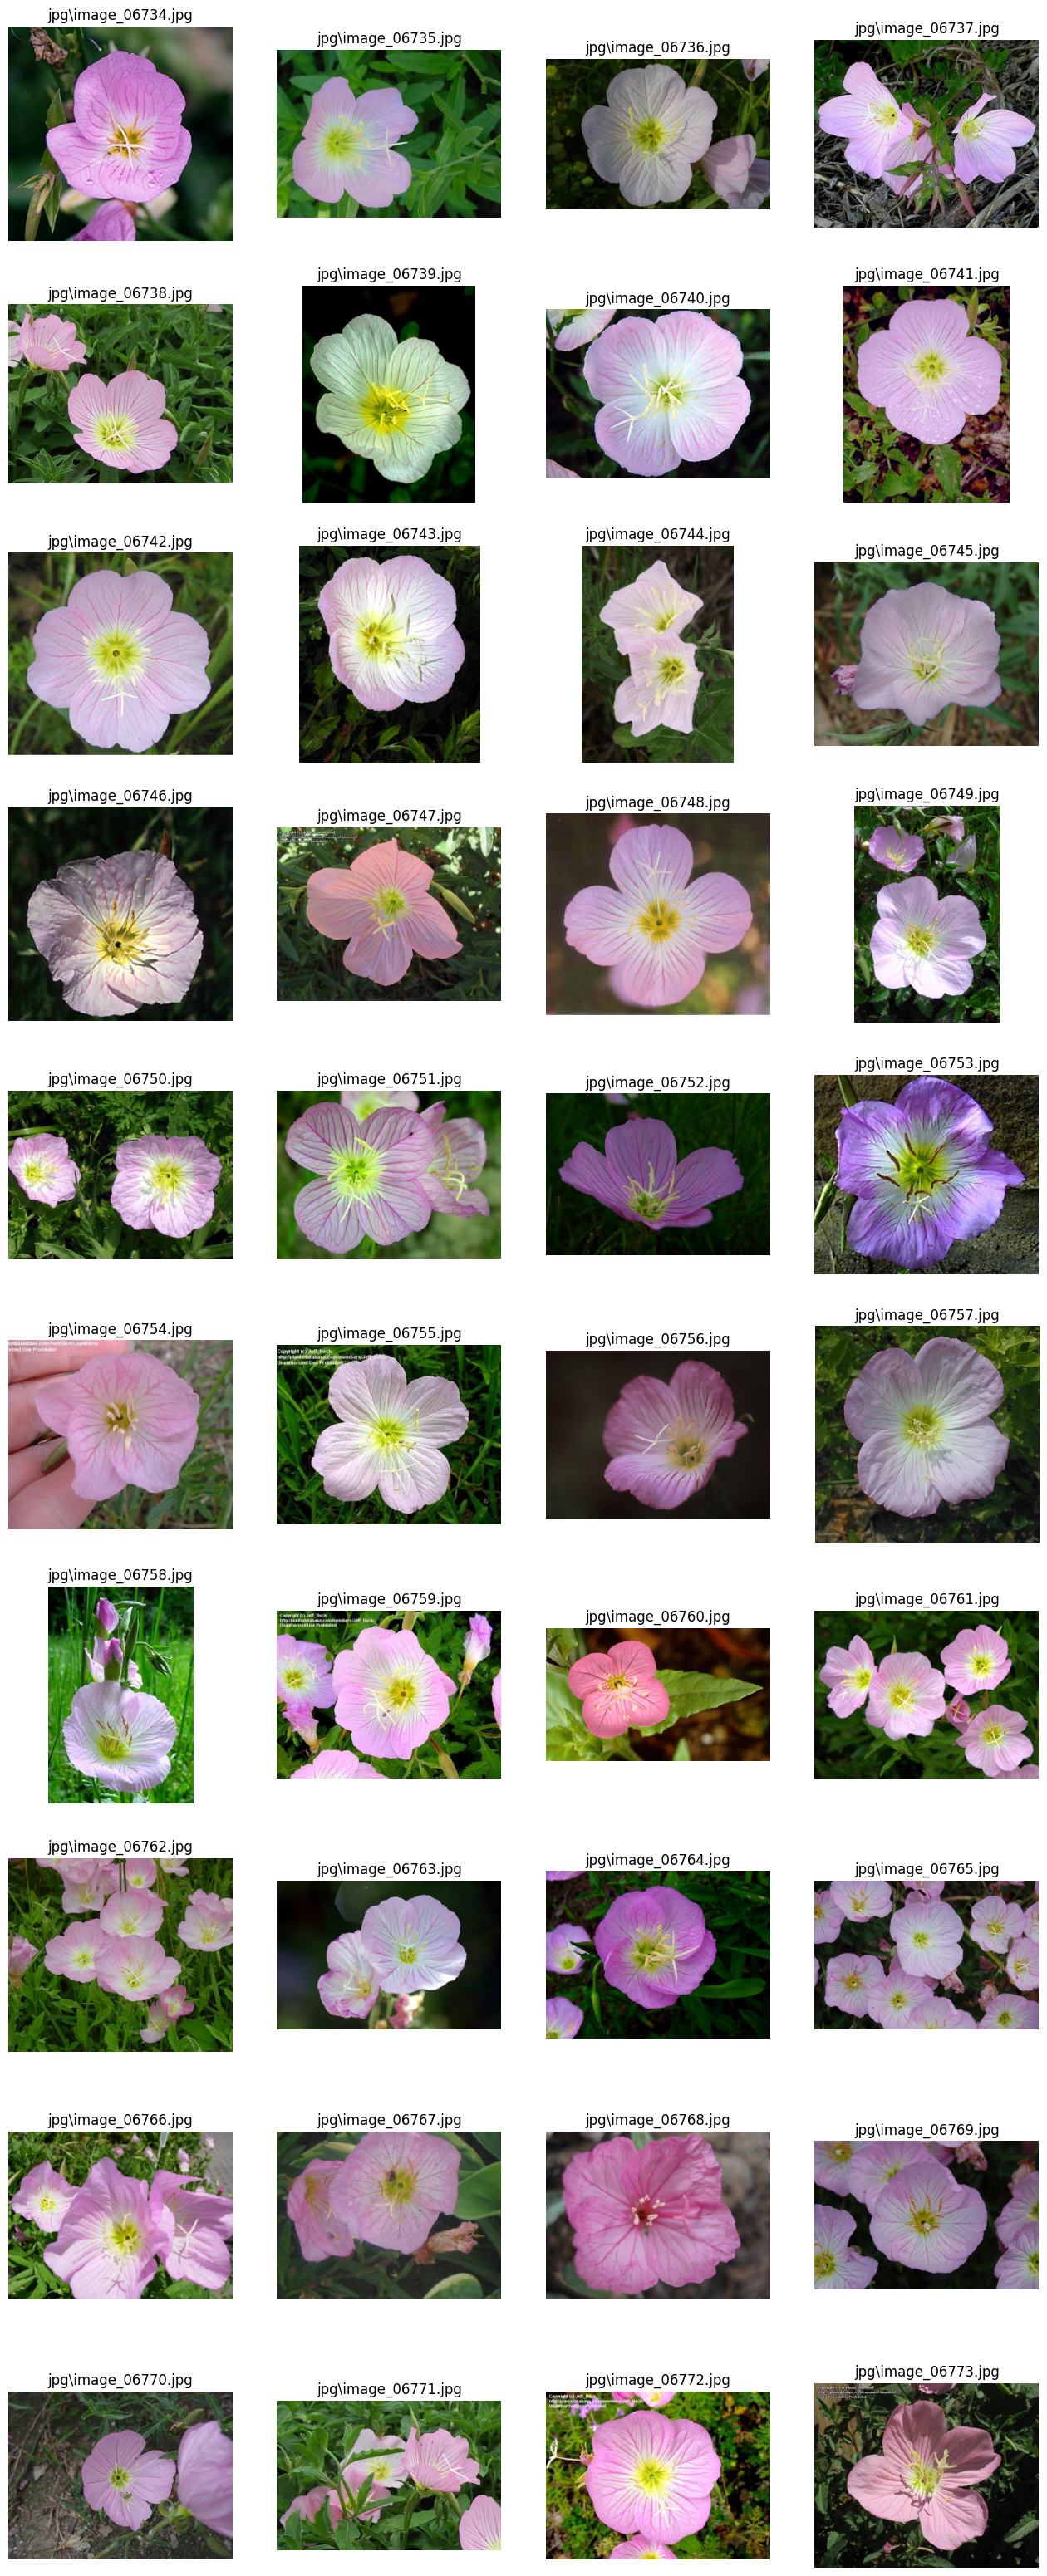

In [10]:
image_files = df[df['labels'] == 1].data.values.tolist()


num_rows = (len(image_files) // 4)   

fig_width = 4 * 4
fig_height = 4 * num_rows

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(fig_width, fig_height))

for i, file_path in enumerate(image_files):
    image = mpimg.imread(file_path)
    
    row_idx = i // 4
    col_idx = i % 4
    
    axes[row_idx, col_idx].imshow(image)
    
    axes[row_idx, col_idx].set_title(file_path)
    
    axes[row_idx, col_idx].axis("off")
plt.show()


In [11]:
x = df['data']
y = df['labels']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, stratify= y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, stratify=y_test)

In [12]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((7370,), (7370,), (409,), (409,), (410,), (410,))

In [13]:
train = pd.DataFrame({'data': x_train, 'labels': y_train}).astype('str')
test = pd.DataFrame({'data': x_test, 'labels': y_test}).astype('str')
val = pd.DataFrame({'data': x_val, 'labels': y_val}).astype('str')

In [14]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', zoom_range= 0.2,
                                    shear_range=0.2, 
                                   preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=preprocess_input
)

In [15]:
train_data = train_datagen.flow_from_dataframe(train, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224), shuffle=False)
test_data = test_datagen.flow_from_dataframe(test, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224),  shuffle=False)
val_data = val_datagen.flow_from_dataframe(val, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224), shuffle=False)

Found 7370 validated image filenames belonging to 102 classes.
Found 409 validated image filenames belonging to 102 classes.
Found 410 validated image filenames belonging to 102 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

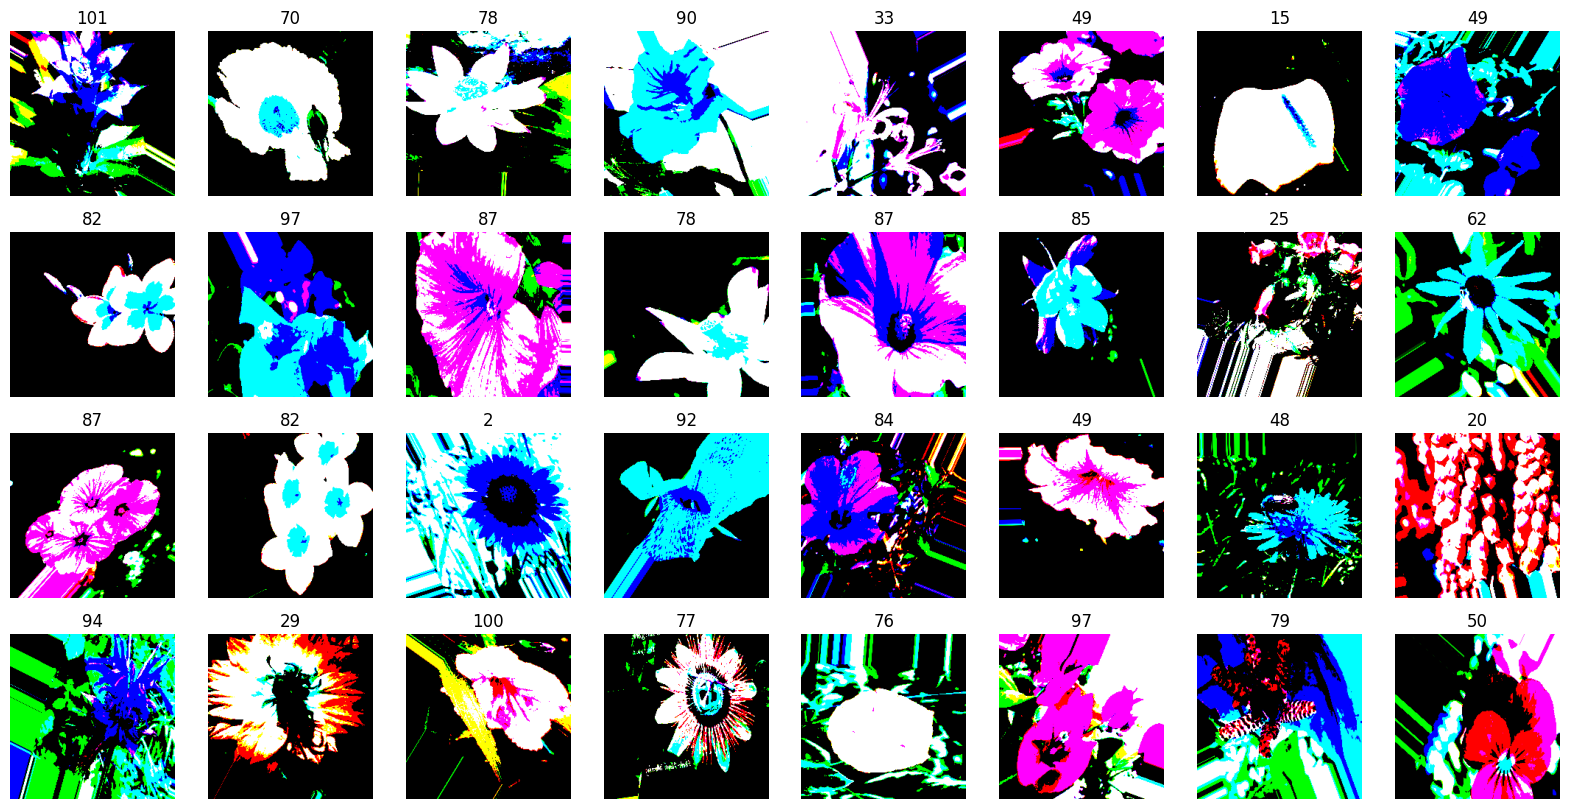

In [16]:
fig, axes = plt.subplots(4, 8, figsize = (20, 10))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(np.argmax(train_data[0][1][i]))
    ax.imshow(train_data[0][0][i])
    ax.axis('off')


plt.show()

In [17]:
def build_model(train_data, val_data):
    Base = ResNet50(include_top=False, input_shape=(224, 224, 3))
    for layer in Base.layers[:-15]:
        layer.trainable = False
    
#     model = Sequential()
#     model.add(Base)
#     model.add(GlobalAveragePooling2D())
#     model.add(Flatten())
#     model.add(BatchNormalization())
#     model.add(Dropout(.3)) 
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(.3))
#     model.add(Dense(102, activation='softmax'))
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])
#     history = model.fit(
#         train_data,
#         steps_per_epoch=len(train_data),
#         epochs=115, validation_data=(val_data), callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True))
    

# ------------------------------------------------------------------------------------------------------------------------------------------>  
#     model = Sequential()
    
#     model.add(Base)
    
#     model.add(GlobalAveragePooling2D())
    
#     model.add(Flatten())
    
#     model.add(BatchNormalization())

#     model.add(Dropout(0.2))
#     model.add(Dense(1024, activation='relu',
#                     # kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)
#              ))
    
    
    
#     model.add(Dropout(0.2))
#     model.add(Dense(512, activation='relu', 
#                     # kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)
#              ))
#     model.add(Dropout(0.2))
    
    
#     model.add(Dense(102, activation='softmax'))
#     model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])
    
#     history = model.fit(train_data, validation_data=val_data, batch_size=32, epochs=200,
#                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
#                        )

# ------------------------------------------------------------------------------------------------------------------------------------------>
    model = Sequential()
    
    model.add(Base)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Flatten())
    
    model.add(BatchNormalization())

    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu',
                    # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
             ))
    
    
    
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', 
                    # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
             ))
    model.add(Dropout(0.2))
    
    
    model.add(Dense(102, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])
    
    history = model.fit(train_data, validation_data=val_data, batch_size=32, epochs=200,
                       callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
                       )


    return model, history, model.summary() 

In [18]:
def artifacts(model, history, test_data, iterate):
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = test_data.classes
    
    
    conf = confusion_matrix(y_true, y_pred)
    plt.imshow(conf, cmap=plt.cm.twilight_shifted, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.savefig(f'images/Confusion_Matrix_Run({iterate})')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'images/Accuracy_Run({iterate})')
    plt.show()
    plt.close()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'images/Loss_Run({iterate})')
    plt.show()
    plt.close()
    
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'images/Recall_Run({iterate})')
    plt.show()
    plt.close()

    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model precision')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'images/Prescision_Run({iterate})')
    plt.show()
    plt.close()
    

Epoch 1/200
231/231 [==============================] - 156s 596ms/step - loss: 2.6641 - accuracy: 0.4282 - recall: 0.2262 - precision: 0.9256 - val_loss: 0.7149 - val_accuracy: 0.8317 - val_recall: 0.7146 - val_precision: 0.9513
Epoch 2/200
231/231 [==============================] - 112s 487ms/step - loss: 0.7330 - accuracy: 0.8133 - recall: 0.6978 - precision: 0.9324 - val_loss: 0.3230 - val_accuracy: 0.9171 - val_recall: 0.8951 - val_precision: 0.9532
Epoch 3/200
231/231 [==============================] - 196s 848ms/step - loss: 0.3642 - accuracy: 0.8985 - recall: 0.8548 - precision: 0.9487 - val_loss: 0.2713 - val_accuracy: 0.9293 - val_recall: 0.9171 - val_precision: 0.9471
Epoch 4/200
231/231 [==============================] - 139s 602ms/step - loss: 0.2252 - accuracy: 0.9370 - recall: 0.9136 - precision: 0.9646 - val_loss: 0.2138 - val_accuracy: 0.9415 - val_recall: 0.9317 - val_precision: 0.9598
Epoch 5/200
231/231 [==============================] - 113s 491ms/step - loss: 0.143

2023/07/09 20:20:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2

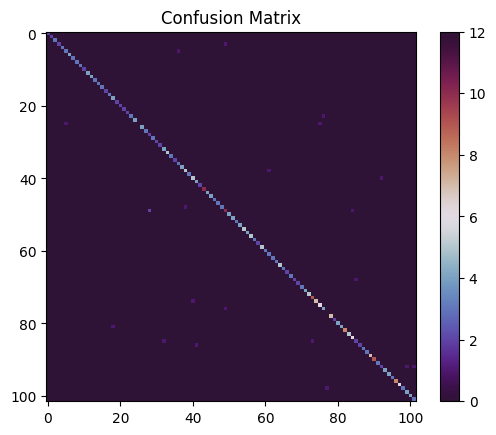

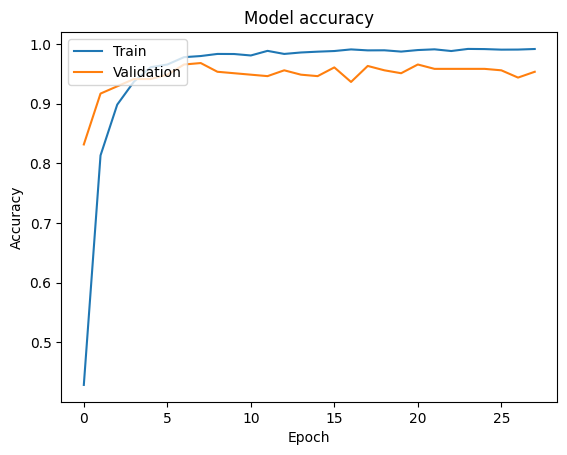

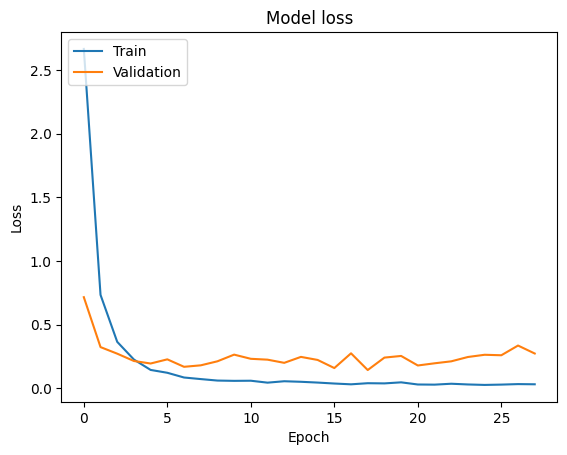

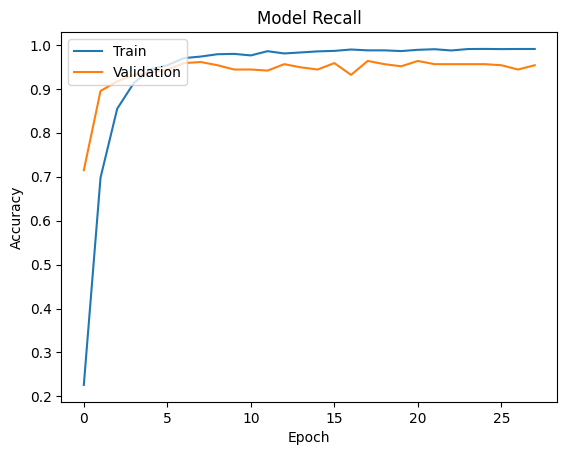

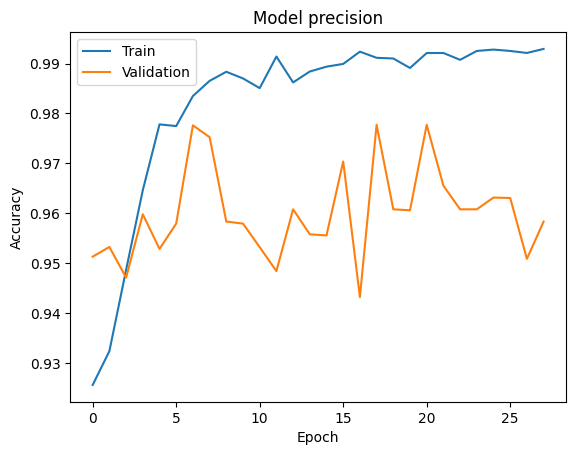

13/13 [==============================] - 2s 108ms/step - loss: 0.1797 - accuracy: 0.9683 - recall: 0.9610 - precision: 0.9752


2023/07/09 20:22:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpk1hx3p72\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpk1hx3p72\model\data\model\assets


In [30]:
iterate_ = next(iterate)
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name='ResNet50')
mlflow.start_run(run_name=f"run_{iterate_}")
mlflow.tensorflow.autolog()

model, history, summary =  build_model(train_data, val_data)
artifacts(model, history, test_data, iterate_)

mlflow.log_artifact(f'images/Confusion_Matrix_Run({iterate_}).png')
mlflow.log_artifact(f'images/Accuracy_Run({iterate_}).png')
mlflow.log_artifact(f'images/Loss_Run({iterate_}).png')
mlflow.log_artifact(f'images/Recall_Run({iterate_}).png')
mlflow.log_artifact(f'images/Prescision_Run({iterate_}).png')


train_metrics = model.evaluate(train_data) 
val_metrics = model.evaluate(val_data)

mlflow.log_metric('loss', train_metrics[0])
mlflow.log_metric('accuracy', train_metrics[1])
mlflow.log_metric('recall', train_metrics[2])
mlflow.log_metric('precision', train_metrics[3])

mlflow.log_metric('val_loss', val_metrics[0])
mlflow.log_metric('val_accuracy', val_metrics[1])
mlflow.log_metric('val_recall', val_metrics[2])
mlflow.log_metric('val_precision', val_metrics[3])

mlflow.tensorflow.log_model(model, 'model')

mlflow.end_run()

In [19]:
def plot_artifacts(run_id):
    fig, axes = plt.subplots(5, 1, figsize=(50, 40))
    for i, path in enumerate(glob.glob(f'artifacts/1/{run_id}/artifacts/*.png')):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

def Evaluate_metrics(run_id, train_data = train_data, val_data = val_data, test_data = test_data):
    final_model = mlflow.tensorflow.load_model(f'runs:/{run_id}/model')
    train = final_model.evaluate(train_data)
    val= final_model.evaluate(val_data)
    test= final_model.evaluate(test_data)
    
    print('-' * 50)
    print('-' * 50)

    print(f'Train Loss: {train[0]}\nTrain Accuracy: {train[1]}\nTrain Recall: {train[2]}\nTrain Precision: {train[3]}')
    
    print('-' * 50)
    print('-' * 50)

    print(f'Validation Loss: {val[0]}\nValidation Accuracy: {val[1]}\nValidation Recall: {val[2]}\nValidation Precision: {val[3]}')
    
    print('-' * 50)
    print('-' * 50)

    print(f'Test Loss: {test[0]}\nTest Accuracy: {test[1]}\nTest Recall: {test[2]}\nTestPrecision: {test[3]}')
    
    print('-' * 50)
    print('-' * 50)
    return final_model


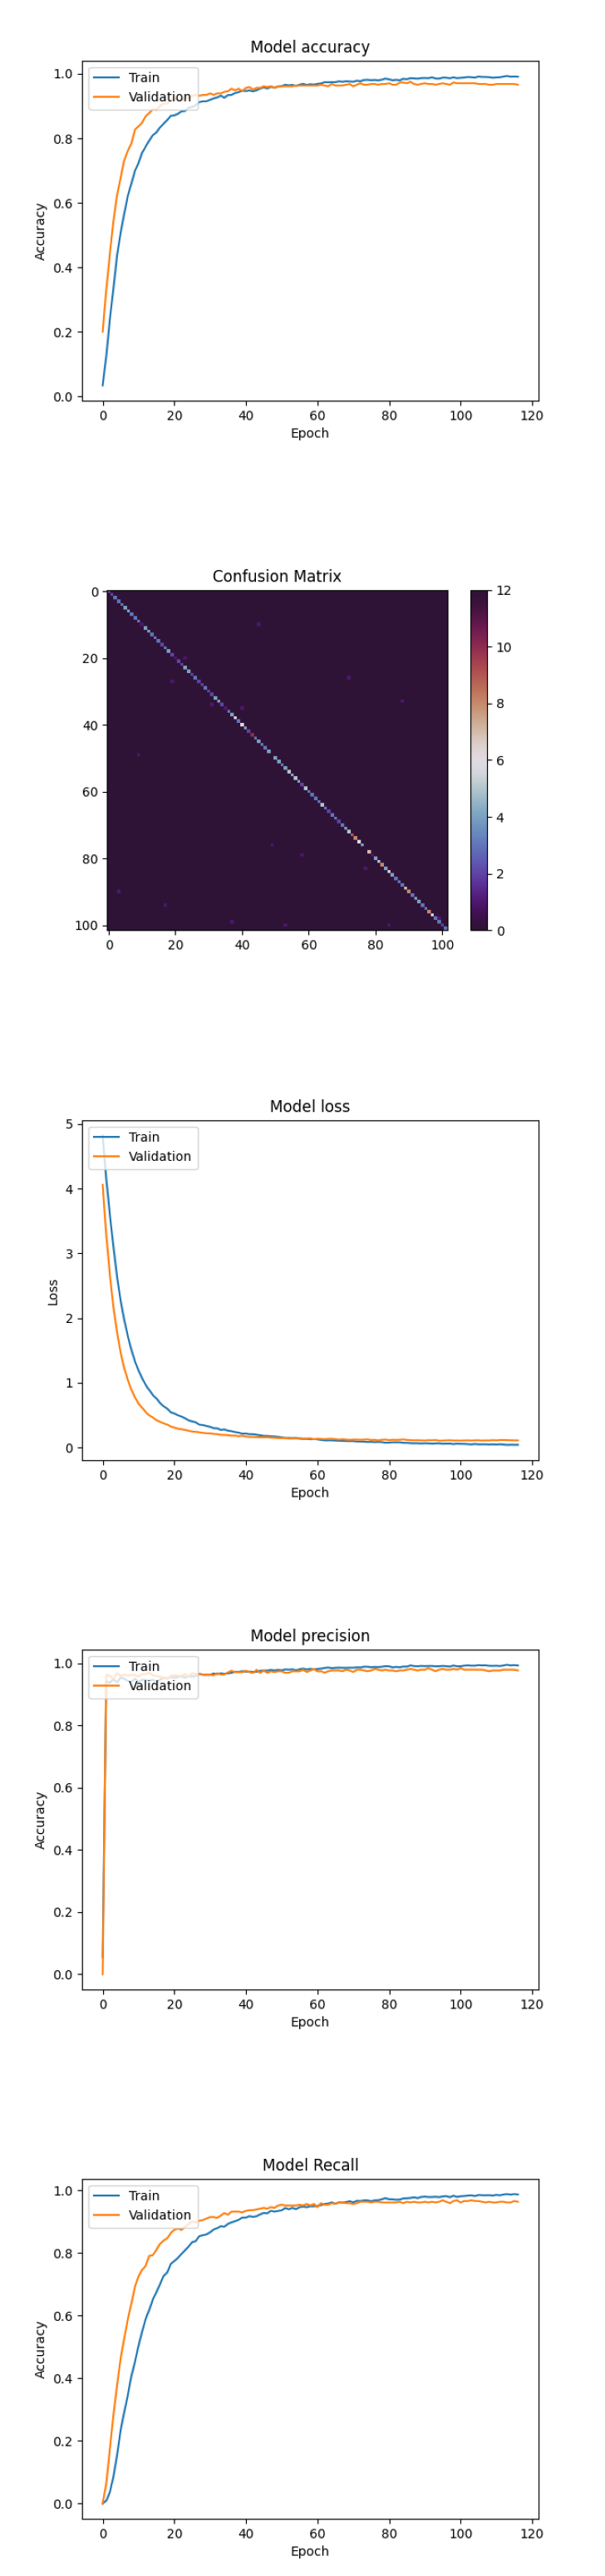

In [20]:
plot_artifacts('f7e9eed4ceb64acb9e3b8eb69dbe909d')

In [24]:
final_model = Evaluate_metrics('f7e9eed4ceb64acb9e3b8eb69dbe909d')

13/13 [==============================] - 2s 124ms/step - loss: 0.0211 - accuracy: 0.9927 - recall: 0.9902 - precision: 0.9951
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.035899702459573746
Train Accuracy: 0.9921302795410156
Train Recall: 0.988466739654541
Train Precision: 0.9944034814834595
--------------------------------------------------
--------------------------------------------------
Validation Loss: 0.04308426380157471
Validation Accuracy: 0.9878048896789551
Validation Recall: 0.9853658676147461
Validation Precision: 0.9901960492134094
--------------------------------------------------
--------------------------------------------------
Test Loss: 0.02107633277773857
Test Accuracy: 0.9926650524139404
Test Recall: 0.9902200698852539
TestPrecision: 0.9950860142707825
--------------------------------------------------
--------------------------------------------------


In [22]:
final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)             

1/1 [==============================] - 1s 1s/step


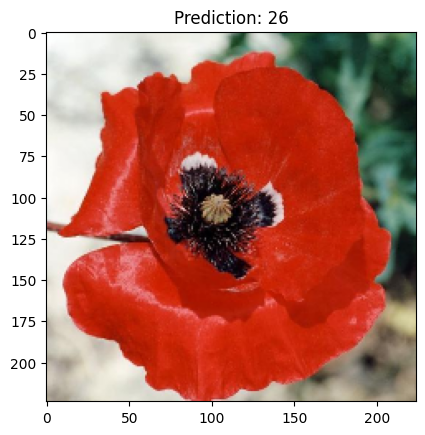

In [23]:
classes = list(train_data.class_indices.keys())

img = cv2.imread('jpg/image_06488.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
plt.imshow(img)
img =np.expand_dims(img,axis=0)
img = preprocess_input(img)
preds = final_model.predict(img)
plt.title(f'Prediction: {classes[np.argmax(preds)]}')
plt.show()

In [25]:
final_model.save('model.h5')